In [76]:
import pandas as pd
import numpy as np
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rc
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

# Load data and write basic statistics

In [77]:
q = 0.05
df50 = pd.read_csv('../data/diff_exp/DE_N250.csv', index_col='Unnamed: 0')
df58 = pd.read_csv('../data/diff_exp/DE_N258.csv', index_col='Unnamed: 0')
dfTime = pd.read_csv('../data/diff_exp/DE_Time.csv', index_col='Unnamed: 0')
detected = np.intersect1d(df50.index.values.tolist(), df58.index.values.tolist())
print(df50.shape)
print(df58.shape)

(14255, 8)
(12962, 8)


In [78]:
sig50 = df50[df50.padj < q].index.values
sig58 = df58[df58.padj < q].index.values
union = list(set(sig50.tolist() + sig58.tolist()))
intersect = np.intersect1d(sig50, sig58)

In [79]:
print('In 50 hrs: ', len(sig50))
print('In 58 hrs: ', len(sig58))
print('In union: ', len(union))
print('In intersection: ', len(intersect))

pval = scipy.stats.hypergeom.sf(len(intersect), len(detected), len(sig58), len(sig50))
print('P-value for intersection: {0:.2g}'.format(pval))

In 50 hrs:  1848
In 58 hrs:  3660
In union:  4767
In intersection:  741
P-value for intersection: 9.5e-27


In [80]:
df50.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_name,logq
WBGene00006927,58107.695125,0.588385,0.013034,45.141332,0.000000e+00,0.000000e+00,vit-3,inf
WBGene00006928,69383.163630,0.578175,0.016531,34.975807,5.248781e-268,3.595940e-264,vit-4,263.444188
WBGene00006925,47640.603016,0.583523,0.016692,34.957623,9.917961e-268,4.529864e-264,vit-1,263.343915
WBGene00001564,44128.365451,-0.509980,0.015109,-33.752939,9.680334e-250,3.315998e-246,icl-1,245.479386
WBGene00018393,12297.551943,0.570439,0.019909,28.652904,1.474937e-180,4.041917e-177,msra-1,176.393413


# Volcano plots

(1831, 8)

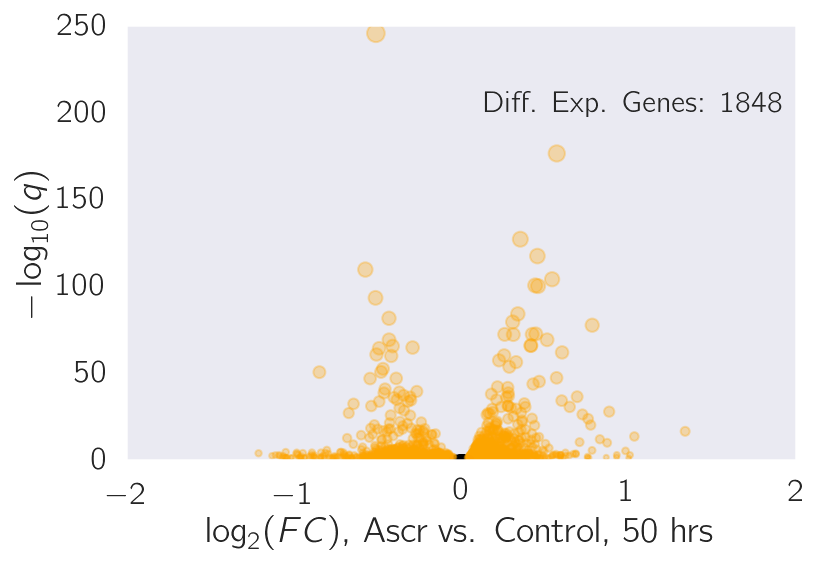

In [81]:
def volcano_plot(df, alpha=0.05):
    sig = df.padj < alpha
    ns = df.padj > 1 - alpha
    
    xns = df[ns].log2FoldChange
    yns = df[ns].logq

    xsig = df[sig].log2FoldChange
    ysig = df[sig].logq.replace(np.inf, 300)
    
    plt.scatter(xns, yns, s=25, alpha=0.01, color='black')
    plt.scatter(xsig, ysig, s=df[sig].logq.apply(np.sqrt) * 5,
                alpha=0.3, color='orange')
    plt.ylabel('$-\log_{10}(q)$')

    maxsig = np.max(xsig.abs())
    lim = maxsig + maxsig / 10
    
    plt.annotate('Diff. Exp. Genes: {0}'.format(len(ysig)),
                 (lim - 10 * maxsig / 10, ysig.max() * 2 / 3),
                 fontsize=15)
    plt.xlim(-lim, lim)

volcano_plot(df50)
plt.xlim(-2, 2)
plt.ylim(0, 250)

plt.xlabel('$\log_2(FC)$, Ascr vs. Control, 50 hrs')
plt.savefig('../volcano_50hrs.pdf', bbox_inches='tight')
df50[df50.padj < 10 ** -10].shape
df50[(df50.padj < q) & (df50.log2FoldChange.abs() < 1)].shape

(3654, 8)

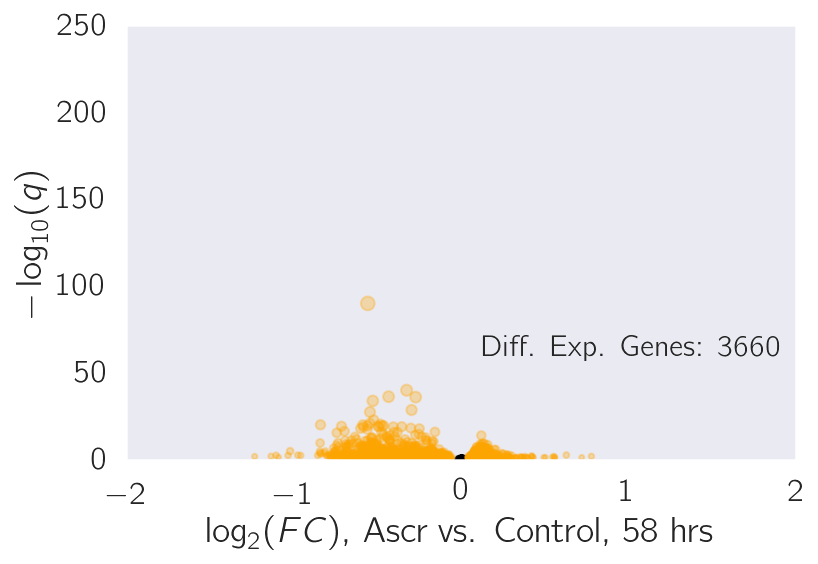

In [82]:
volcano_plot(df58)
plt.ylim(-10, 310)
plt.xlabel('$\log_2(FC)$, Ascr vs. Control, 58 hrs')
plt.savefig('../volcano_58hrs.pdf', bbox_inches='tight')
plt.xlim(-2, 2)
plt.ylim(0, 250)
# df58[(df58.padj < 0.05) & (df58.log2FoldChange > 0)].shape
df58[(df58.padj < q) & (df58.log2FoldChange.abs() < 1)].shape

# Heatmap comparing response to ascr#10 at 50 vs 58 hrs

In [83]:
df50.reset_index(inplace=True)
df58.reset_index(inplace=True)
df50.columns = ['gene'] + df50.columns[1:].tolist()
df58.columns = ['gene'] + df58.columns[1:].tolist()
sub50 = df50[df50.gene.isin(union)].sort_values('gene').copy()
sub58 = df58[df58.gene.isin(union)].sort_values('gene').copy()
merged = sub50.merge(sub58, left_on='gene', right_on='gene', suffixes=('50h', '58h'))

TypeError: __init__() got an unexpected keyword argument 'location'

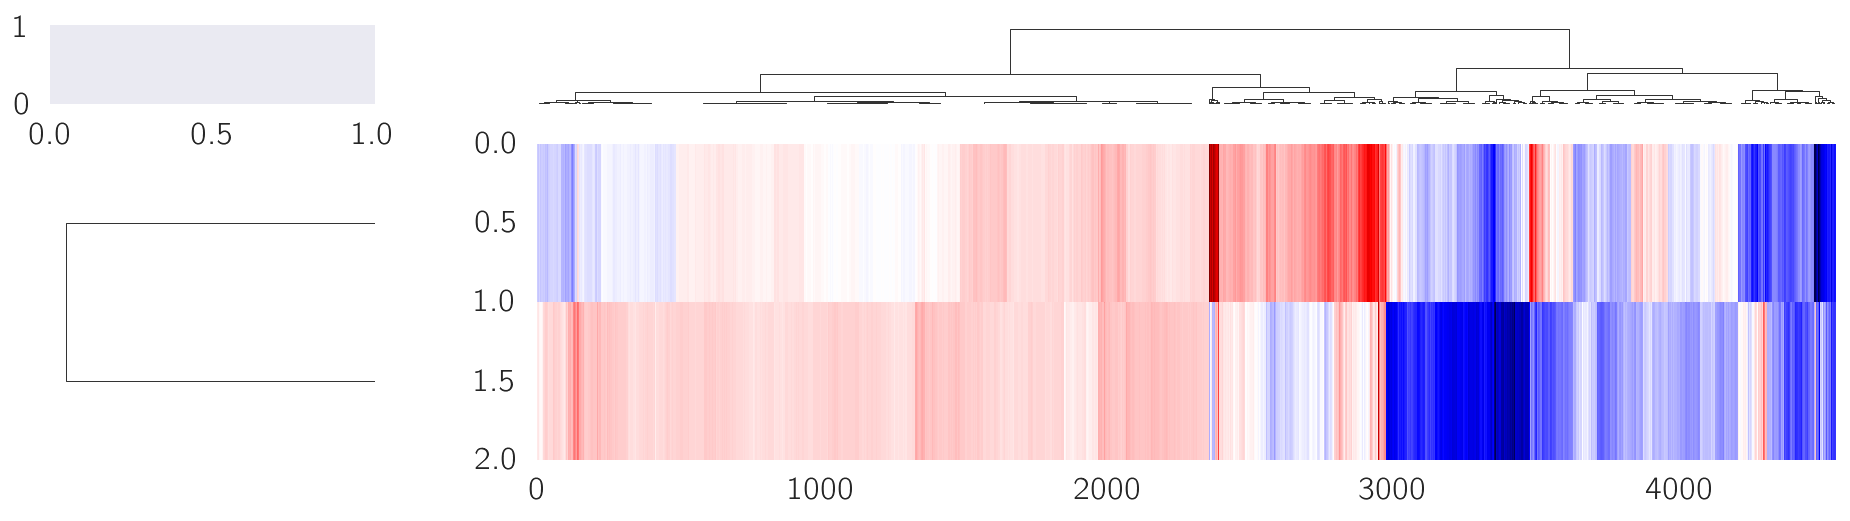

In [88]:
cg = sns.clustermap(merged[['log2FoldChange50h', 'log2FoldChange58h']].T, figsize=(16, 4), cmap='seismic', center=0,
                    vmin=-1, vmax=1, method='ward', row_cluster=True, cbar_kws={'use_gridspec': False, 'location': "right"})
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
ax = cg.ax_heatmap
ax.set_xticks([])
plt.savefig('../heatmap_union.svg', bbox_inches='tight')

[]

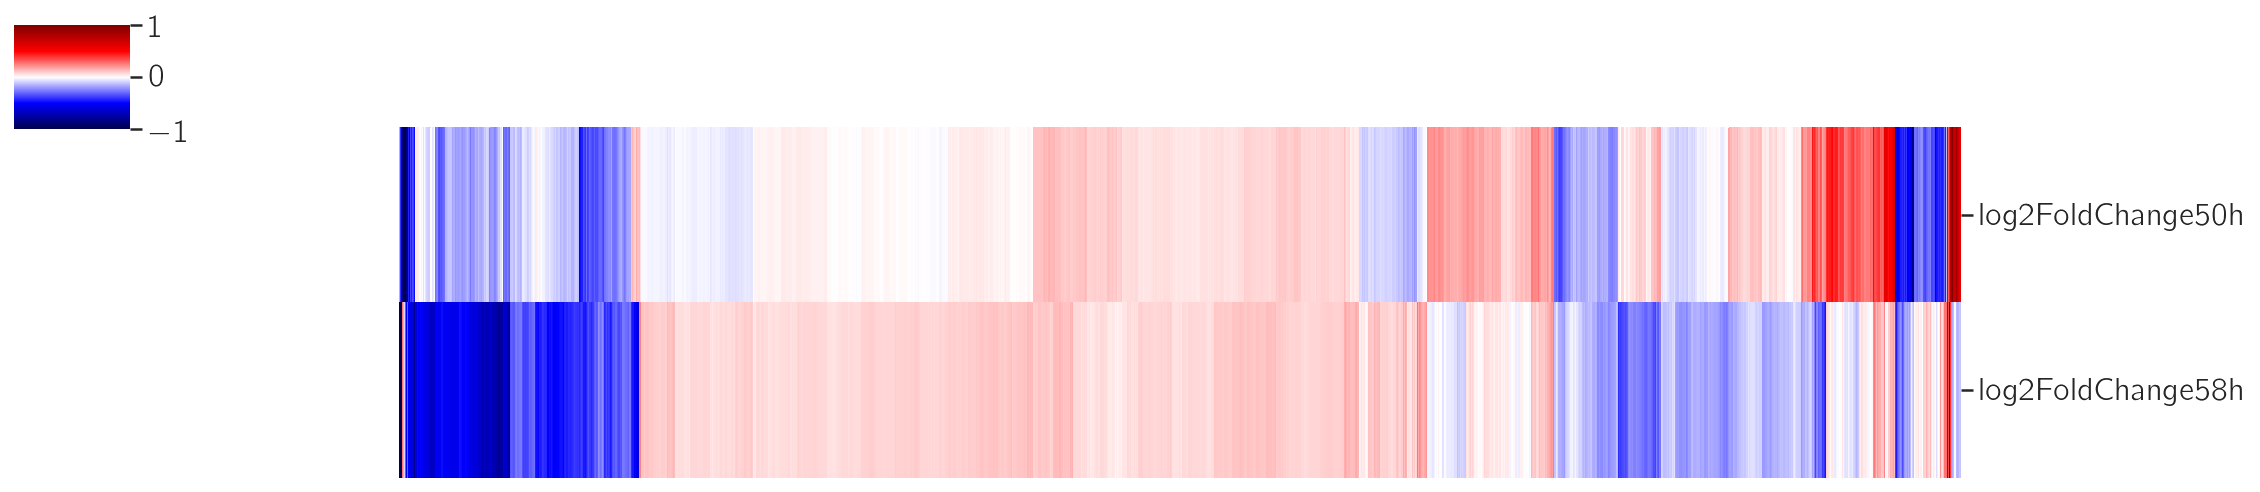

In [86]:
cg = sns.clustermap(merged[['log2FoldChange50h', 'log2FoldChange58h']].T, figsize=(16, 4),
                    cmap='seismic', center=0, vmin=-1, vmax=1, method='centroid',
                    row_cluster=True)
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
ax = cg.ax_heatmap
ax.set_xticks([])

Text(0.5, 0, '$\\log_{10}(p_{adj})$')

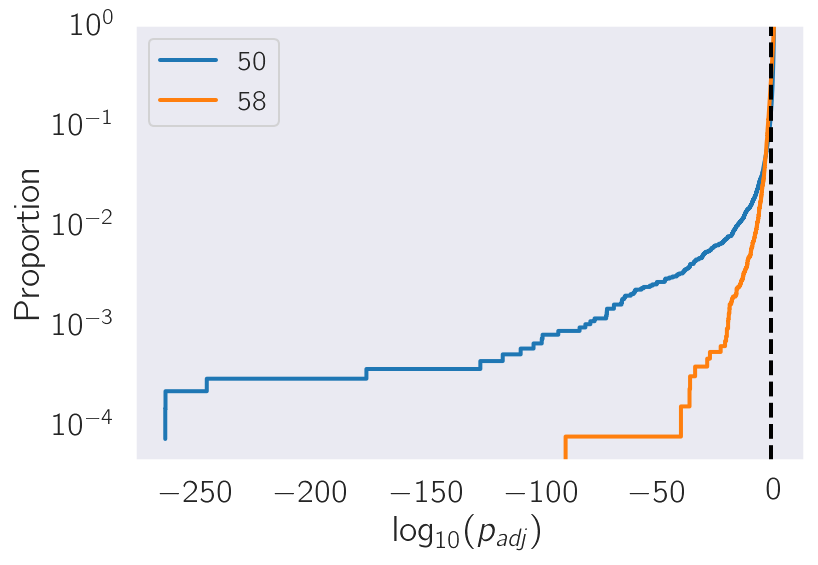

In [87]:
sns.ecdfplot(df50.padj.apply(np.log10), label='50')
sns.ecdfplot(df58.padj.apply(np.log10), label='58')
plt.axvline(np.log10(0.05), color='black', ls='--')
plt.yscale('log')
plt.legend()
plt.xlabel('$\log_{10}(p_{adj})$')

##### 

# Calculate significance of overlap

In [59]:
q = 0.05
# Hypergeom calculation:
df50 = df50[df50.gene.isin(detected)]
df58 = df58[df58.gene.isin(detected)]

# DEGs out of commonly detected expression levels:
sig50 = df50[df50.padj < q].gene.values
sig58 = df58[df58.padj < q].gene.values

# find union:
union = list(set(sig50.tolist() + sig58.tolist()))
intersect = np.intersect1d(sig50, sig58)
print(len(detected))

12421


In [60]:
print('In 50 hrs: ', len(sig50))
print('In 58 hrs: ', len(sig58))
print('In union: ', len(union))
print('In intersection: ', len(intersect))

In 50 hrs:  1667
In 58 hrs:  3627
In union:  4553
In intersection:  741


In [74]:
[M, n, N] = [len(detected),
             np.max([len(sig50), len(sig58)]),
             np.min([len(sig50), len(sig58)])
            ]
k = len(intersect)
scipy.stats.hypergeom.sf(k - 1, M, n, N)

3.272099682500554e-46